In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.fftpack import fft, fftshift, ifft
from scipy.signal import fftconvolve
#plt.style.use('seaborn-colorblind')

plt.style.use('seaborn-talk')
cci=plt.rcParams['axes.prop_cycle'].by_key()['color']


import seaborn as sns
from matplotlib.transforms import Bbox

sns.set(style='white',font_scale=2)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
lsc= ['-','--']
lw = [4,3]
lc = ['Gaussian','Top Hat']
cc = [cci[0],cci[1]]

In [5]:
mas = 4.84814e-9       #radians
au  = 1.495978707e11   #meters
c   = 2.99792458e8     #meters
pc  = 3.0857e16        #meters
re  = 2.8179403227e-15 #meters

In [6]:
dlens = 389.*pc
dpsr  = 620.*pc
lo    = c/(314.5e6)

la   = 1.0e5*au
T    = 0.03*au
A    = 0.3*au
inc  = 1.0e-5

R  = la**2./(4.*np.pi**2.*A*np.cos(inc)**3.*np.sqrt(1.-la**2./(4.*np.pi**2.*A**2.)*np.tan(inc)**2.))
s  = 1. - dlens/dpsr
r  = R/dlens
t  = T/dlens

def dn(dne,lo):
    re  = 2.8179403227e-15 #meters
    return -1. * lo**2. * dne * re / (2.*np.pi)

dne1 = 0.003*1e6
dne2 = 0.3*1e6

In [7]:
print(r'R = {:.2f} pc'.format(R/pc))
print(r'T = {} AU'.format(T/au))
print(r'r = {:.2f}'.format(r))
print(r't = {:.4f} mas'.format(t/mas))
print(r's = {:.4f}'.format(s))

R = 4829.05 pc
T = 0.03 AU
r = 12.41
t = 0.0771 mas
s = 0.3726


### Lens Profile:

In [8]:
def gaus(x,m,s):
    return np.median(np.diff(x))/((2*np.pi)**(1/2)*s)*np.exp(-(x-m)**2/(2*s**2))
def zinner(x,R,T):
    Rp = (R+T)/2
    return 2*(2*Rp*(x+T/2))**(1/2)
def zouter(x,R,T):
    return 2*T*(1+R/(2*x))**(1/2)
def tophat(x,xmin,xmax):
    return np.median(np.diff(x))/(xmax-xmin)*(xmin<x)*(x<xmax)

In [9]:
x = np.arange(-300.*mas*dlens,300.*mas*dlens,T/1000.)
idxp=np.searchsorted(x,T/2,side='left')
idxm=np.searchsorted(x,-T/2,side='left')
idx0=np.searchsorted(x,0,side='left')

# approximate profile
z0 = np.zeros(x.shape)
z0[idxm:idxp] = zinner(x[idxm:idxp],R,T)
z0[idxp:] = zouter(x[idxp:],R,T) 

# the profile to be convolved
z1 = np.zeros(x.shape)
z1[idx0:] = zouter(x[idx0:],R,T) 

# Change x and z to units of 
x,z0,z1 = x/T,z0/T,z1/T

# Convolve
z0c = fftconvolve(z1,tophat(x,-0.5,0.5),mode='same')
z1c = fftconvolve(z1,gaus(x,0,1/(2*np.sqrt(2*np.log(2)))),mode='same')

### Gradient:

In [10]:
gradz0 = np.gradient(z0,np.median(np.diff(x)))
gradz0[idxp-1:idxp+1] = np.nan
gradz0[idxm-1:idxm+1] = np.nan
gradz1 = np.gradient(z1,np.median(np.diff(x)))
gradz0c= np.gradient(z0c,np.median(np.diff(x)))
gradz0c[idxp-1:idxp+1] = np.nan
gradz0c[idxm-1:idxm+1] = np.nan
gradz1c= np.gradient(z1c,np.median(np.diff(x)))

In [11]:
z0       = z0[len(x)//4:3*len(x)//4]
z1       = z1[len(x)//4:3*len(x)//4]
z0c      = z0c[len(x)//4:3*len(x)//4]
z1c      = z1c[len(x)//4:3*len(x)//4]
gradz0   = gradz0[len(x)//4:3*len(x)//4]
gradz1   = gradz1[len(x)//4:3*len(x)//4]
gradz0c  = gradz0c[len(x)//4:3*len(x)//4]
gradz1c  = gradz1c[len(x)//4:3*len(x)//4]
x        = x[len(x)//4:3*len(x)//4]

In [12]:
grad = [gradz1c,gradz0c]
z    = [z1c,z0c]


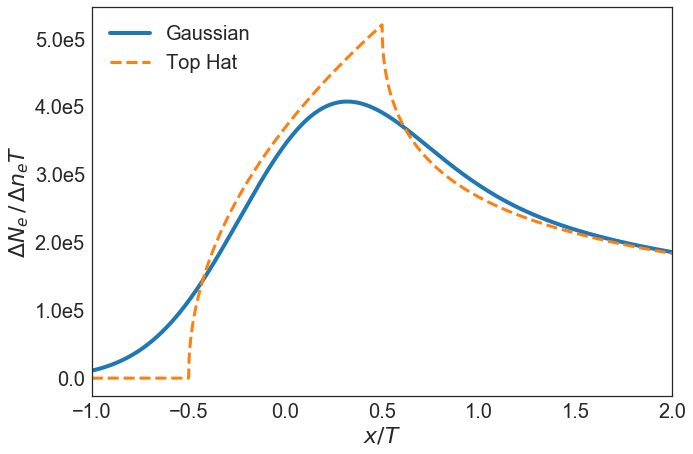

In [13]:
fig,ax = plt.subplots()
for i in range(len(z)):
    ax.plot(x,z[i],cc[i],ls=lsc[i],label=lc[i],linewidth=lw[i])
ax.set_ylabel(r'$\Delta N_e \,/\, \Delta n_e T$')
ax.legend(loc='upper left')
ax.set_xlabel(r'$x/T$')
ax.set_xlim(-1,2)
yticks = ax.get_yticks()
ylabels = []
for ytick in yticks:
    if ytick == 0:
        ylabels += [str(ytick)]
    else:
        ylabels += [str(ytick/1e5)+'e5']
ax.set_yticklabels(ylabels)

plt.savefig('../lens_profiles_smooth.pdf')

In [14]:
theta = x*T/dlens
def beta(theta,dn,s,gradz):
    return theta + dn * s * gradz
def mu(theta,dn,s,gradz):
    return 1./np.gradient(beta(theta,dn,s,gradz),np.median(np.diff(theta)))
def defl(theta,dn,s,gradz):
    return -dn * s * gradz

### Overdense Solution

In [15]:
idx=[[0,1942713,1944779,1945752,2001097,-1],[0,2001094,-1]]

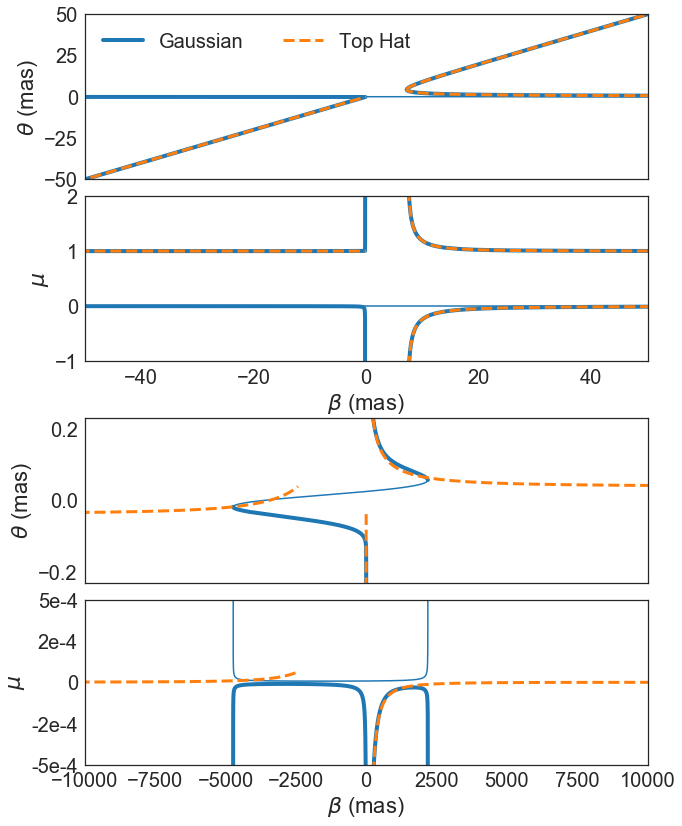

In [20]:
fig,ax = plt.subplots(4,1,figsize=(10,6*2))#,sharex=True)

#for a in ax.flatten():
#    a.axhline(0,color='black')

for i in range(len(grad)):
    j=0
    ax[0].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
                   theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],linestyle=lsc[i],label=lc[i],linewidth=lw[i])
    for j in range(1,len(idx[i])-1):
        if i==0 and j==2:
            ax[0].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
                   theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],linestyle=lsc[i],linewidth=1.5)
        else:
            ax[0].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
                   theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],linestyle=lsc[i],linewidth=lw[i])
ax[0].set_ylim(-50,50)
ax[0].set_xlim(-50,50)
ax[0].legend(loc='upper left',ncol=2)
ax[0].set_ylabel(r'$\theta$ (mas)')
for i in range(len(grad)):
    for j in range(len(idx[i])-1):
        if i==0 and j==2:
            ax[1].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
                 mu(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ),
                   cc[i],linestyle=lsc[i],label=lc[i],linewidth=1.5)
        else:
            ax[1].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
                 mu(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ),
                   cc[i],linestyle=lsc[i],label=lc[i],linewidth=lw[i])
    #for j in range(len(idx[i])-1):
    #    ax[1].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
    #         mu(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ),cc[i],linestyle=lstyls[i])
ax[1].set_xlim(-50,50)
ax[1].set_ylim(-1,2)
ax[1].set_xlabel(r'$\beta$ (mas)')
ax[1].set_ylabel(r'$\mu$')
ax[0].get_xaxis().set_visible(False)


for i in range(len(grad)):
    j=0
    ax[2].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
               theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],ls=lsc[i],label=lc[i],linewidth=lw[i])
    for j in range(1,len(idx[i])-1):
        if i==0 and j==2:
            ax[2].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
               theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],ls=lsc[i],linewidth=1.5)
        else:
            ax[2].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
               theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],ls=lsc[i],linewidth=lw[i])
ax[2].set_ylim(-3*t/mas,3*t/mas)
ax[2].set_xlim(-10000,10000)
#ax[2].legend(loc='upper left')
ax[3].set_xlabel(r'$\beta$ (mas)')
ax[2].set_ylabel(r'$\theta$ (mas)')
for i in range(len(grad)):
    j=0
    ax[3].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
         mu(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ),cc[i],ls=lsc[i],label=lc[i],linewidth=lw[i])
    for j in range(1,len(idx[i])-1):
        if i==0 and j==2:
            ax[3].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
             mu(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ),cc[i],linestyle=lsc[i],linewidth=1.5)
        else:
            ax[3].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
             mu(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ),cc[i],linestyle=lsc[i],linewidth=lw[i])
ax[3].set_ylim(-5e-4,5e-4)
ax[3].set_ylabel(r'$\mu$')
ax[3].set_xlim(-10000,10000)

plt.tight_layout()
x0 = 0.1438125
x1 = 0.9253715277777775
ax[0].set_position(Bbox([[x0, 0.7661+0.004],  [x1, 0.9613]]))
ax[1].set_position(Bbox([[x0, 0.5416+0.01+0.004*2],  [x1, 0.7368+0.01+0.004]]))
ax[2].set_position(Bbox([[x0, 0.3170-0.01-0.004],  [x1, 0.5123-0.01-0.004*2]]))
ax[3].set_position(Bbox([[x0, 0.0925], [x1, 0.2877-0.004]]))

yticks = ax[3].get_yticks()
ylabels = []
for ytick in yticks:
    if ytick == 0:
        ylabels += [str(int(ytick))]
    else:
        ylabels += [str(int(ytick*1e4))+'e-4']
ax[3].set_yticklabels(ylabels)
ax[2].get_xaxis().set_visible(False)

plt.savefig('../lens_behaviour_overdense_smooth.pdf',bbox_inches='tight')

### Underdense Solution:

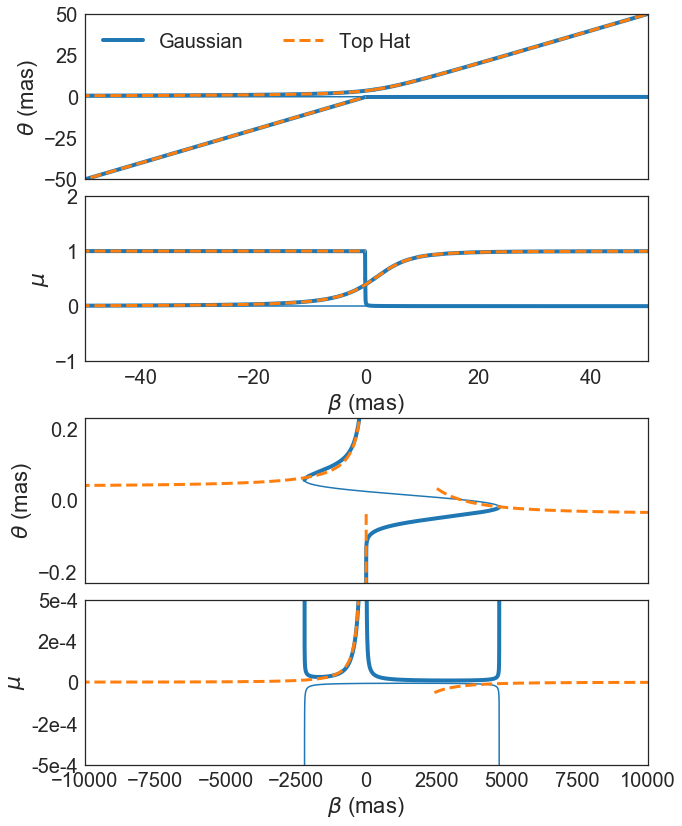

In [19]:
fig,ax = plt.subplots(4,1,figsize=(10,6*2))

#for a in ax.flatten():
#    a.axhline(0,color='black')

for i in range(len(grad)):
    j=0
    ax[0].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
                   theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],linestyle=lsc[i],label=lc[i],linewidth=lw[i])
    for j in range(1,len(idx[i])-1):
        if i==0 and j==2:
            ax[0].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
                   theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],linestyle=lsc[i],linewidth=1.5)
        else:
            ax[0].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
                   theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],linestyle=lsc[i],linewidth=lw[i])
ax[0].set_ylim(-50,50)
ax[0].set_xlim(-50,50)
ax[0].legend(loc='upper left',ncol=2)
ax[0].set_ylabel(r'$\theta$ (mas)')
for i in range(len(grad)):
    for j in range(len(idx[i])-1):
        if i==0 and j==2:
            ax[1].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
                 mu(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ),
               cc[i],linestyle=lsc[i],label=lc[i],linewidth=1.5)
        else:
            ax[1].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
                 mu(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ),
               cc[i],linestyle=lsc[i],label=lc[i],linewidth=lw[i])
ax[1].set_xlim(-50,50)
ax[1].set_ylim(-1,2)
ax[1].set_xlabel(r'$\beta$ (mas)')
ax[1].set_ylabel(r'$\mu$')
ax[0].get_xaxis().set_visible(False)

for i in range(len(grad)):
    j=0
    ax[2].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
               theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],ls=lsc[i],label=lc[i],linewidth=lw[i])
    for j in range(1,len(idx[i])-1):
        if i==0 and j==2:
            ax[2].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
               theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],ls=lsc[i],linewidth=1.5)
        else:
            ax[2].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
               theta[idx[i][j]:idx[i][j+1]]/mas,cc[i],ls=lsc[i],linewidth=lw[i])
ax[2].set_ylim(-3*t/mas,3*t/mas)
ax[2].set_xlim(-10000,10000)
#ax[2].legend(loc='upper left')
ax[3].set_xlabel(r'$\beta$ (mas)')
ax[2].set_ylabel(r'$\theta$ (mas)')
for i in range(len(grad)):
    j=0
    ax[3].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
         mu(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ),cc[i],ls=lsc[i],label=lc[i],linewidth=lw[i])
    for j in range(1,len(idx[i])-1):
        if i==0 and j==2:
            ax[3].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
             mu(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ),cc[i],linestyle=lsc[i],linewidth=1.5)
        else:
            ax[3].plot(beta(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )/mas,
             mu(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ),cc[i],linestyle=lsc[i],linewidth=lw[i])
ax[3].set_ylim(-5e-4,5e-4)
ax[3].set_ylabel(r'$\mu$')
ax[3].set_xlim(-10000,10000)

plt.tight_layout()
x0 = 0.1438125
x1 = 0.9253715277777775
ax[0].set_position(Bbox([[x0, 0.7661+0.004],  [x1, 0.9613]]))
ax[1].set_position(Bbox([[x0, 0.5416+0.01+0.004*2],  [x1, 0.7368+0.01+0.004]]))
ax[2].set_position(Bbox([[x0, 0.3170-0.01-0.004],  [x1, 0.5123-0.01-0.004*2]]))
ax[3].set_position(Bbox([[x0, 0.0925], [x1, 0.2877-0.004]]))

yticks = ax[3].get_yticks()
ylabels = []
for ytick in yticks:
    if ytick == 0:
        ylabels += [str(int(ytick))]
    else:
        ylabels += [str(int(ytick*1e4))+'e-4']
ax[3].set_yticklabels(ylabels)
ax[2].get_xaxis().set_visible(False)

plt.savefig('../lens_behaviour_underdense_smooth.pdf',bbox_inches='tight')

### Magnification and Deflection Angle

#### From our analytic analysis:

In [17]:
# Maximum magnification
t**(3/2)/(s*dn(-dne2,lo)*np.sqrt((r+t)/4))

9.0093923436656304e-05

In [18]:
# Minimum angular separation
s*dn(-dne2,lo)*np.sqrt((r+t)/(t/2))/mas

2421.1277521039374

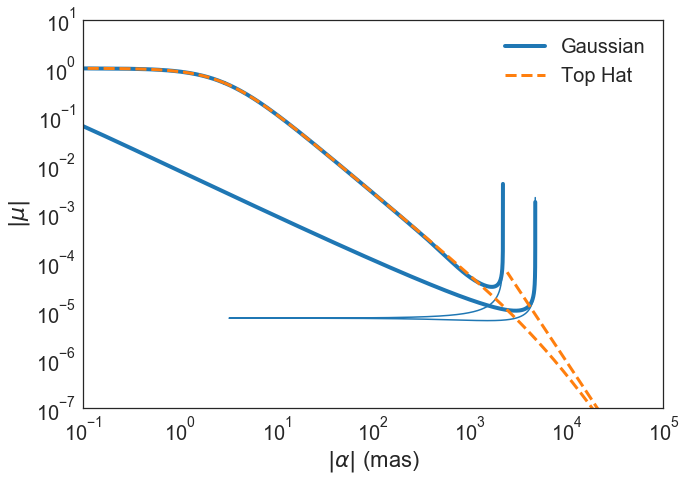

In [19]:
fig,ax = plt.subplots()
for i in range(len(grad)):
    j=0
    ax.plot(np.absolute(defl(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ))/mas,
               np.absolute(mu(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )),
                cc[i],ls=lsc[i],label=lc[i],linewidth=lw[i])
    for j in range(1,len(idx[i])-1):
        if i==0 and j==2:
            ax.plot(np.absolute(defl(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ))/mas,
               np.absolute(mu(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )),
                cc[i],ls=lsc[i],linewidth=1.5)
        else:
            ax.plot(np.absolute(defl(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ))/mas,
               np.absolute(mu(theta[idx[i][j]:idx[i][j+1]],dn(-dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )),
                cc[i],ls=lsc[i],linewidth=lw[i])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e-1,1e5)
ax.set_ylim(1e-7,1e1)
ax.set_xlabel(r'$|\alpha|$ (mas)')
ax.set_ylabel(r'$|\mu|$')
plt.legend()
plt.savefig('../mu_v_deflection_smooth.pdf')

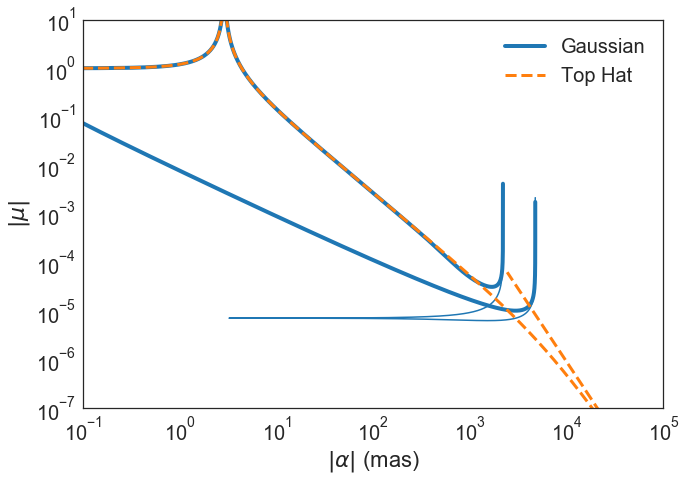

In [20]:
# The spike occurs because we are not looking at mu/mu0 
# both images diverge here so actually we can ignore the spike
fig,ax = plt.subplots()
for i in range(len(grad)):
    j=0
    ax.plot(np.absolute(defl(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ))/mas,
               np.absolute(mu(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )),
                cc[i],ls=lsc[i],label=lc[i],linewidth=lw[i])
    for j in range(1,len(idx[i])-1):
        if i==0 and j==2:
            ax.plot(np.absolute(defl(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ))/mas,
               np.absolute(mu(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )),
                cc[i],ls=lsc[i],linewidth=1.5)
        else:
            ax.plot(np.absolute(defl(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  ))/mas,
               np.absolute(mu(theta[idx[i][j]:idx[i][j+1]],dn(dne2,lo),s,grad[i][idx[i][j]:idx[i][j+1]]  )),
                cc[i],ls=lsc[i],linewidth=lw[i])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e-1,1e5)
ax.set_ylim(1e-7,1e1)
ax.set_xlabel(r'$|\alpha|$ (mas)')
ax.set_ylabel(r'$|\mu|$')
plt.legend()